In [95]:
# Initalize imports
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout, LeakyReLU, Input, concatenate, add, Reshape, Conv2D, Activation
from keras.optimizers import Adam, RMSprop, Adagrad, SGD
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical, plot_model
from glob import glob
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import collections
import os
from scipy.spatial.distance import cosine
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImageDataGenerator
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [96]:
# Define parameters
ROLLNUMBER = 4228
NUM_CLASSES = 6
labels_dict = {"freeway":0,"mountain":1,"palace":2,"river":3,"ship":4,"stadium":5}
# Batch size is a hyperparameter, feel free to change this. You may also change the number of epochs.
BATCH_SIZE = 32
EPOCHS = 1000

In [103]:
# Define the model
def DML():
    inputs1 = layers.Input((1024, 1))
    inputs2 = layers.Input((1024, 1))
    inputs1_r = layers.Reshape((32, 32, 1))(inputs1)
    inputs2_r = layers.Reshape((32, 32, 1))(inputs2)
    merged =  layers.Concatenate(axis=-1)([inputs1_r, inputs2_r])
    conv2d_1 = layers.Conv2D(16, (3, 3), padding = "same")(merged)
    conv2d_2 = layers.Conv2D(16, (3, 3), padding = "same")(conv2d_1)
    conv2d_3 = layers.Conv2D(16, (3, 3), padding = "same")(conv2d_2)
    added = tf.keras.layers.Add()([conv2d_3, conv2d_1])
    conv2d_4 = layers.Conv2D(16, (3, 3), strides=(2,2), padding = "same")(added)
    conv2d_5 = layers.Conv2D(16, (3, 3), padding = "same")(conv2d_4)
    conv2d_6 = layers.Conv2D(16, (3, 3), strides=(2,2),padding = "same")(added)
    added_2 = layers.Add()([conv2d_5, conv2d_6])
    leaky = layers.LeakyReLU(alpha=0.1)(added_2)
    flatten = layers.Flatten()(leaky)
    x = layers.Dense(1024)(flatten)
    #x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    #x = layers.Dropout(0.2)(x)
    x = layers.Dense(512)(x)
    #x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    #x = layers.Dropout(0.2)(x)
    x = layers.Dense(64)(x)
    #x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    #x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)
    #x = layers.BatchNormalization()(x)
    output = layers.Activation('softmax')(x)
    model = Model(inputs=[inputs1, inputs2], outputs=output)
    # compile model
    model.compile(optimizer = Adam(lr= 0.001), 
                   loss ='binary_crossentropy',
                   metrics = ['accuracy'])
    # get model summary
    model.summary()
    plot_model(model, to_file='model_plot.png', show_shapes=True)
    return model


In [104]:
# Initialize the model
dml = DML()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
reshape_18 (Reshape)            (None, 32, 32, 1)    0           input_19[0][0]                   
__________________________________________________________________________________________________
reshape_19 (Reshape)            (None, 32, 32, 1)    0           input_20[0][0]                   
____________________________________________________________________________________________

In [99]:
# load the train and test data
dml_train_df = pd.read_csv('dml_train.csv')
dml_test_df = pd.read_csv('dml_test.csv')
# get number of train and test samples
train_samples = dml_train_df.shape[0]
test_samples = dml_test_df.shape[0]
dml_test_df

,sat_path,str_path,label
0,SatView/Features/palace_118.npy,StreetView/Features/8414017403_85fb3ae8b4_o.npy,0
1,SatView/Features/stadium_126.npy,StreetView/Features/37171819984_67ae978755_o.npy,1
2,SatView/Features/ship_080.npy,StreetView/Features/38665588205_039652c360_o.npy,0
3,SatView/Features/freeway_664.npy,StreetView/Features/4484446180_aef4387c10_o.npy,0
4,SatView/Features/river_489.npy,StreetView/Features/14085655533_c0b49a77f0_o.npy,0
...,...,...,...
8395,SatView/Features/freeway_686.npy,StreetView/Features/5347801653_4af53628f2_o.npy,0
8396,SatView/Features/palace_499.npy,StreetView/Features/2326811876_7915f2a914_o.npy,0
8397,SatView/Features/freeway_579.npy,StreetView/Features/6084384410_7106ecb8fb_o.npy,1
8398,SatView/Features/river_581.npy,StreetView/Features/2320216434_6247104508_o.npy,1


In [100]:
# write the data generator function to load the data
def dml_data_generator(df, batch_size = 32, mode='train'):
    X1 = []
    X2 = []
    y = []
    for index, row in df.iterrows():
        # get feature vectors for images
        sat_vector = np.load(row['sat_path']).reshape(1024,1)
        str_vector = np.load(row['str_path']).reshape(1024,1)
        X1.append(sat_vector)
        X2.append(str_vector)
        y.append(row['label'])
    # get number of samples
    samples_per_epoch = len(X1)
    # get number of batches for given samples and batch size
    number_of_batches = samples_per_epoch//batch_size
    counter=0

    while 1:
        # create data for batch 
        X1_batch = np.array(X1[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        X2_batch = np.array(X2[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        y_batch = np.array(y[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        counter += 1
        yield [X1_batch, X2_batch], y_batch

        #restart counter to yeild data in the next epoch as well
        if counter >= number_of_batches:
            counter = 0

In [101]:
# get train and test data
dml_train_gen = dml_data_generator(dml_train_df,batch_size=BATCH_SIZE)
dml_test_gen = dml_data_generator(dml_test_df,batch_size=BATCH_SIZE)

In [206]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor ='val_acc', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.001)
checkpoint = ModelCheckpoint("Results.h5", monitor = 'val_acc', verbose=1, save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)
callback = [checkpoint, learning_rate_reduction]
# train the model on train and test data as validation data
dml.fit(dml_train_gen, steps_per_epoch = train_samples // BATCH_SIZE, validation_data = dml_test_gen, 
                    validation_steps = test_samples // BATCH_SIZE, epochs = EPOCHS, callbacks = callback)

In [207]:
# get the saved model
dml = keras.models.load_model("Results.h5")

In [208]:
# sort the scores calculated for images
def sort_by_value(dict_obj):
    return collections.OrderedDict(sorted(dict_obj.items(), key=lambda kv: kv[1]))

In [209]:
# find similar images against a query image
from scipy import spatial
def get_similar(query_fv_path,database,metric='dml',query_view='str',batch_size=32):
    results = {}
    query_vector = np.load(query_fv_path).reshape(1,1024,1)
    if query_view == 'sat':
        filtered_db = database[database['view'] == 'str']
        for index, row in filtered_db.iterrows():
            search_vector = np.load(row['fv_path']).reshape(1,1024,1)
            with tf.device('/cpu:0'):
                if metric == 'dml':
                    score = dml.predict([query_vector, search_vector])
                else:
                    score = 1 - spatial.distance.cosine(query_vector, search_vector)
            results[row['img_path']] = score
    elif query_view == 'str':
        filtered_db = database[database['view'] == 'sat']
        for index, row in filtered_db.iterrows():
            search_vector = np.load(row['fv_path']).reshape(1,1024,1)
            with tf.device('/cpu:0'):
                if metric == 'dml':
                    score = dml.predict([search_vector, query_vector])
                else:
                    score = 1 - spatial.distance.cosine(search_vector, query_vector)
            results[row['img_path']] = score
    return sort_by_value(results)

In [210]:
# view the results for the retrieved images against the query image
def view_results(results_dict,n=5):
    fig = figure(figsize=(15,15))
    files = list(results_dict.keys())
    for i in range(n):
        a=fig.add_subplot(1,n,i+1)
        image = imread(files[i])
        imshow(image)
        axis('off')

In [211]:
# customize database dataframe according to the requirements
def get_db(df,imgs_per_classes=5):
    classes = ['freeway','mountain','palace','river','ship', 'stadium']
    sat_df = df[df['view'] == 'sat']
    str_df = df[df['view'] == 'str']
    db = pd.DataFrame({},columns=df.columns)
    for c in classes:
        sat_sample = sat_df[sat_df['class'] == c].sample(imgs_per_classes,random_state=ROLLNUMBER)
        str_sample = str_df[str_df['class'] == c].sample(imgs_per_classes,random_state=ROLLNUMBER)
        db = pd.concat([db,sat_sample,str_sample])
    return db.sample(frac=1,random_state=ROLLNUMBER).reset_index(drop=True)

In [212]:
# retrieve database of images and feature paths
full_database = pd.read_csv('Retrieval_Database.csv')
database = get_db(full_database,imgs_per_classes=5)

In [213]:
# search / retrieve images against query images
def search(query_fv_path,database,dist_metric='dml',num_results=5):
    results = get_similar(query_fv_path,database, dist_metric)
    view_results(results)

In [214]:
# select 5 str images from database for every class
mountain = "StreetView/Features/42102_73212f0ee4_o.npy"
freeway = "StreetView/Features/689138_169c62e409_o.npy"
palace = "StreetView/Features/4331920_d6cf41874c_o.npy"
river = "StreetView/Features/13862273_8fec95833c_o.npy"
ship = "StreetView/Features/5295892_13f8a9a9cc_o.npy"
stadium = "StreetView/Features/9823516_c99916d332_o.npy"

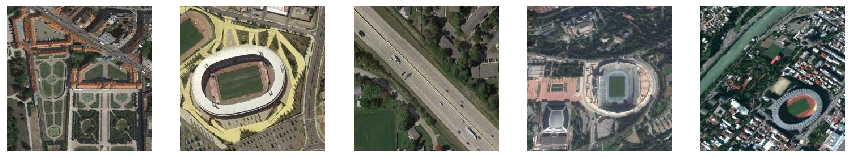

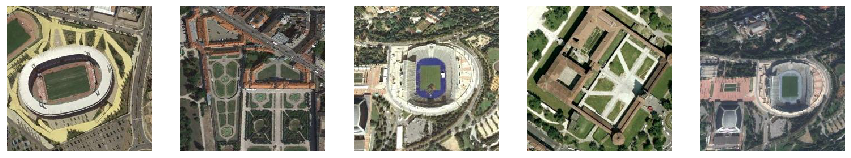

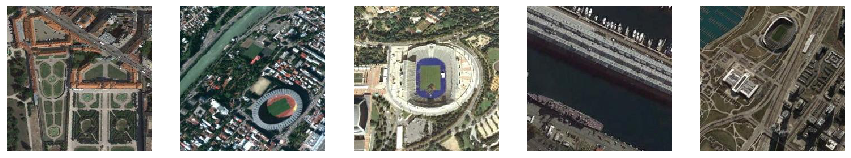

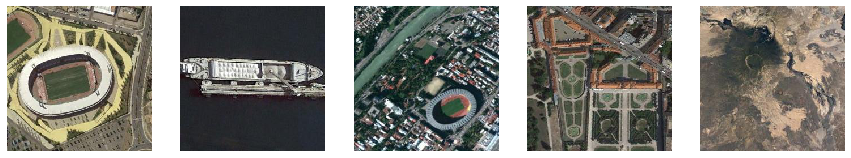

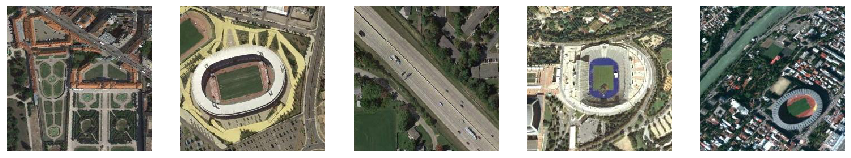

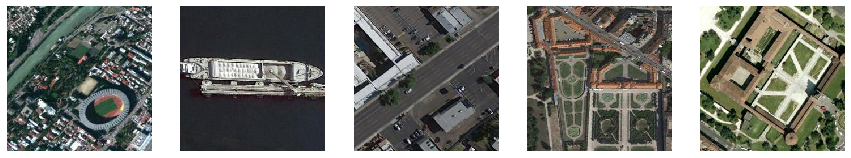

In [215]:
# check for every class image
search(mountain, database, 'cosine')
search(freeway, database,  'cosine')
search(palace, database,  'cosine')
search(river, database,  'cosine')
search(ship, database,  'cosine')
search(stadium, database,  'cosine')